# 

In [13]:
import bayes3d as b
import os
import jax.numpy as jnp
import jax
import bayes3d.genjax
import genjax
import matplotlib
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [14]:
import flax.linen as nn
from flax.training.train_state import TrainState
import flax
import optax

In [15]:
import os

In [16]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7008/static/


In [17]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=2.0
)

b.setup_renderer(intrinsics)
# model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
# meshes = []
# for idx in range(1,22):
#     mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
#     b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [18]:
import trimesh
box_width = 0.02
hammer_width = 0.05
hand_length = 0.15
b1 = trimesh.creation.box(
    np.array(jnp.array([hand_length, box_width,box_width])),
    np.array(b.transform_from_pos(jnp.array([0.0, 0.0, 0.0])))
)
b2 = trimesh.creation.box(
    np.array(jnp.array([hammer_width,hammer_width, hammer_width])),
    np.array(b.transform_from_pos(jnp.array([hand_length/2 - hammer_width/2, 0.0, 0.0])))
)
b3 = trimesh.creation.box(
    np.array(jnp.array([hammer_width,hammer_width, hammer_width])),
    np.array(b.transform_from_pos(jnp.array([-hand_length/2 + hammer_width/2, 0.0, 0.0, ])))
)
m1 = trimesh.util.concatenate([b1,b2])
m2 = trimesh.util.concatenate([b1,b2,b3])
b.show_trimesh("1", m2)

b.utils.mesh.export_mesh(m1, "m1.obj")
b.utils.mesh.export_mesh(m2, "m2.obj")
table_mesh_path = b.utils.get_assets_dir() + '/sample_objs/cube.obj'

box_mesh = b.utils.make_cuboid_mesh(jnp.array([0.1, 0.1, 0.3]))
b.RENDERER.add_mesh(m1)
b.RENDERER.add_mesh(m2)
b.RENDERER.add_mesh(box_mesh)
# b.RENDERER.add_mesh_from_file(box_mesh_path, scaling_factor=1e-3)
b.RENDERER.add_mesh_from_file(table_mesh_path, scaling_factor=1e-6)

In [19]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.7, 0.5]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)

In [20]:
FORK_IDX, KNIFE_IDX, CHEESEITZ_BOX_IDX, TABLE_IDX = 0, 1, 2, 3

In [21]:
SHIFT_MIN = -0.2
SHIFT_SCALE = 0.4
CHEESEITZ_BOX_CONTACT_PARAMS = jnp.array([0.0, 0.1, 0.0])

In [22]:
def fork_spoon_from_known_params(is_fork, shift, noise):
    indices = jax.lax.cond(is_fork,
                           lambda: jnp.array([TABLE_IDX, CHEESEITZ_BOX_IDX, FORK_IDX]),
                           lambda: jnp.array([TABLE_IDX, CHEESEITZ_BOX_IDX, KNIFE_IDX]))

    box_dims = b.RENDERER.model_box_dims[indices]
    root_poses = jnp.array([table_pose, table_pose, table_pose])
    parents = jnp.array([-1, 0, 0])
    contact_params = jnp.array([[0.0, 0.0, 0.0],
                                [*CHEESEITZ_BOX_CONTACT_PARAMS],
                                [shift*jnp.cos(jnp.pi/12), -0.05 + shift*jnp.sin(jnp.pi/12), noise + 10*jnp.pi/12]])
    faces_parents = jnp.array([0, 2, 2])
    faces_child = jnp.array([0, 3, 3])
    poses = b.scene_graph.poses_from_scene_graph(
        root_poses, box_dims, parents, contact_params, faces_parents, faces_child)
    camera_pose = jnp.eye(4)
    rendered = b.RENDERER.render(
        jnp.linalg.inv(camera_pose) @ poses , indices
    )[...,:3]
    print(contact_params[2, :])
    return (is_fork, rendered)

[-0.19318517 -0.10176381  2.6179938 ]
[-0.19318517 -0.10176381  2.6179938 ]


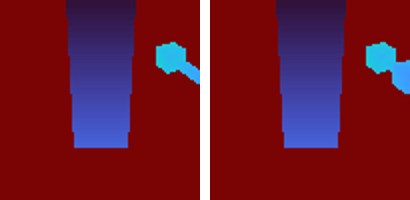

In [25]:
ss = -0.2
b.viz.hstack_images([b.viz.scale_image(b.get_depth_image(fork_spoon_from_known_params(True, ss, 0)[1][...,2]), 2),
                     b.viz.scale_image(b.get_depth_image(fork_spoon_from_known_params(False, ss, 0)[1][...,2]), 2)])

In [13]:
def fork_spoon_generator(key, noise=0.0):
    noise_key, is_fork_key, shift_key = jax.random.split(key, 3)
    noise = noise * jax.random.normal(noise_key)
    is_fork = jax.random.bernoulli(is_fork_key)
    shift = SHIFT_MIN + SHIFT_SCALE * jax.random.uniform(shift_key)
    return fork_spoon_from_known_params(is_fork, shift, noise)

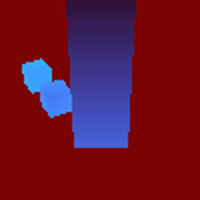

In [14]:
b.viz.scale_image(b.get_depth_image(fork_spoon_generator(jax.random.PRNGKey(0))[1][...,2]), 2)

In [15]:
make_onehot = lambda b: jax.lax.cond(b, lambda: jnp.array([0.0, 1.0]), lambda: jnp.array([1.0, 0.0]))

In [16]:
@jax.jit
def make_batch(batch_keys, noise):
    #is_forks, imgs = zip(*map(fork_spoon_generator, batch_keys))
    #img_batch = jnp.concatenate([img[:,:,2].reshape(1, 100, 100, 1) for img in imgs], 0)
    #label_batch = jnp.array([make_onehot(is_fork) for is_fork in is_forks])
    #return img_batch, label_batch
    batch_size = batch_keys.shape[0]
    def loop_body(i, imgs_labels):
        imgs, labels = imgs_labels
        label, img = fork_spoon_generator(batch_keys[i], noise)
        return (imgs.at[i, :, :, 0].set(img[:, :, 2]),
                labels.at[i, :].set(make_onehot(label)))
    return jax.lax.fori_loop(0, batch_keys.shape[0],
                             loop_body,
                             (jnp.zeros((batch_size, 100, 100,1)), jnp.zeros((batch_size, 2))))

In [17]:
N_TRAIN = 50000
N_TEST = 2000

In [18]:
#key1, key2 = jax.random.split(jax.random.PRNGKey(0), 2)
#train_data = make_batch(jax.random.split(key2, N_TRAIN))

In [19]:
#jnp.savez('train_data_1e5_2.npz', *train_data)

In [20]:
#t1 = jnp.load('train_data_1e5_1.npz')
#t2 = jnp.load('train_data_1e5_2.npz')

In [21]:
#t1_imgs, t1_labels = t1['arr_0'], t1['arr_1']
#t2_imgs, t2_labels = t2['arr_0'], t2['arr_1']

In [22]:
#imgs = jnp.vstack([t1_imgs, t2_imgs])
#labels = jnp.vstack([t1_labels, t2_labels])

In [23]:
#train_data = (imgs, labels)

In [24]:
#jnp.savez('train_data_1e5.npz', *train_data)

In [36]:
test_data = make_batch(jax.random.split(jax.random.PRNGKey(2718), N_TEST), noise=0.5)

In [37]:
jnp.savez('test_data_noisy.npz', *test_data)

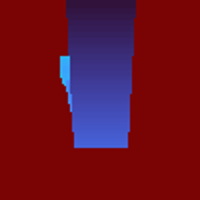

In [44]:
b.viz.scale_image(b.get_depth_image(test_data[0][22, :, :, 0]), 2)

In [45]:
noise_key = jax.random.PRNGKey(2718)

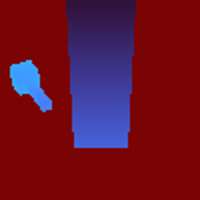

In [64]:
noise_key = jax.random.split(noise_key, 1)[0]
noise = 0.5 * jax.random.normal(noise_key)
b.viz.scale_image(b.get_depth_image(fork_spoon_from_known_params(True, 0.15, noise)[1][:, :, 2]) , 2)